In [1]:
import numpy as np
import deepxde as dde
import tensorflow as tf
R = 0.1
L= 1
t_last=1

data_x = np.array([[0.014598, 0.014112], [0.014598, 0.016107131]])

data_sigma = np.array([[43584350.6], [43195861.8]])  


X_test=np.array([[0.014598, 0.014112], [0.014598, 0.016107131]])
y_test=np.array([[43584350.6], [43195861.8]]) 

print(data_x)
print(data_sigma)
assert data_x is not None, "data_x is None!"
assert data_sigma is not None, "data_sigma is None!"
print(type(data_x))  # Should print <class 'numpy.ndarray'>
print(type(data_sigma))  # Should print <class 'numpy.ndarray'>


# Use the DataSet data object to create a data-driven task
data = dde.data.dataset.DataSet(X_train=data_x, y_train=data_sigma, X_test=X_test, y_test=y_test)

# Define the network for σ
layer_size = [2] + [50] * 3 + [1]  # 2 inputs (x, y ) -> hidden layers -> 1 output (σ)
activation = "tanh"
initializer = "Glorot uniform"
net_sigma = dde.nn.FNN(layer_size, activation,initializer)

# Define the model
model_sigma = dde.Model(data, net_sigma)

# Compile the model with data
model_sigma.compile("adam", lr=1e-3)

# Train the model
losshistory, train_state = model_sigma.train(epochs=5000)


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
[[0.014598   0.014112  ]
 [0.014598   0.01610713]]
[[43584350.6]
 [43195861.8]]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Compiling model...
Building feed-forward neural network...

'build' took 0.187268 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(



'compile' took 0.306147 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.88e+15]    [1.88e+15]    []  
1000      [1.88e+15]    [1.88e+15]    []  
2000      [1.88e+15]    [1.88e+15]    []  
3000      [1.88e+15]    [1.88e+15]    []  
4000      [1.88e+15]    [1.88e+15]    []  
5000      [1.88e+15]    [1.88e+15]    []  

Best model at step 5000:
  train loss: 1.88e+15
  test loss: 1.88e+15
  test metric: []

'train' took 2.090983 s



In [21]:
def pde_C_L(x, C_L):
    dC_L_dt = dde.grad.jacobian(C_L, x, i=0, j=2)
    dC_L_dx2 = dde.grad.hessian(C_L, x, i=0, j=0)
    dC_L_dy2 = dde.grad.hessian(C_L, x, i=0, j=1)
    eq = dC_L_dt - (1/3.8) * (dC_L_dx2 + dC_L_dy2)
    return eq

In [28]:
import numpy as np
import deepxde as dde

class RandomPointConstraintCallback(dde.callbacks.Callback):
    def __init__(self, num_pairs, model_sigma, L, t_last, model):
        self.num_pairs = num_pairs
        self.model_sigma = model_sigma
        self.L = L
        self.t_last = t_last
        self.model = model  # Attach the model to the callback

    def on_epoch_end(self):
        # Access the model from train_state
    

        constraint_loss = 0.0
        for _ in range(self.num_pairs):
            # Sample random points in the domain
            x_A, y_A = np.random.uniform(-self.L, self.L), np.random.uniform(-self.L, self.L)
            x_B, y_B = np.random.uniform(-self.L, self.L), np.random.uniform(-self.L, self.L)

            # Get sigma values for random points
            sigma_A = self.model_sigma.predict(np.array([[x_A, y_A]]))
            sigma_B = self.model_sigma.predict(np.array([[x_B, y_B]]))

            # Compute the constraint
            VH, R, T = 1.0, 1.0, 1.0  # Modify constants as needed
            exponent = (VH / (R * T)) * (sigma_A - sigma_B)

            # Get C values at the random points
            C_A = model.predict(np.array([[x_A, y_A, self.t_last]]))
            C_B = model.predict(np.array([[x_B, y_B, self.t_last]]))

            # Calculate constraint loss
            constraint_loss += np.mean((C_A - C_B * np.exp(exponent))**2)

        # Log the constraint loss
        print(f"Constraint loss after epoch: {constraint_loss / self.num_pairs}")

# Create the callback object
constraint_callback = RandomPointConstraintCallback(
    num_pairs=10,
    model_sigma=model_sigma,
    L=L,
    t_last=t_last,
    model=model
)



Compiling model...
Building feed-forward neural network...
'build' took 0.026352 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.395774 s

Training model...

0         [6.10e-02, 4.00e+02]    [5.96e-02, 4.00e+02]    []  


C:\Users\yesda\AppData\Local\Temp\ipykernel_21212\1463995230.py:35: RuntimeWarning: overflow encountered in exp
  constraint_loss += np.mean((C_A - C_B * np.exp(exponent))**2)


Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: 0.14496839395724237
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf


C:\Users\yesda\AppData\Local\Temp\ipykernel_21212\1463995230.py:35: RuntimeWarning: overflow encountered in square
  constraint_loss += np.mean((C_A - C_B * np.exp(exponent))**2)


Constraint loss after epoch: 6.464144181925803
Constraint loss after epoch: 5.83938390747644
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: 19471.607799900743
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: 13.101932285074145
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf


C:\Users\yesda\AppData\Local\Temp\ipykernel_21212\1463995230.py:35: RuntimeWarning: overflow encountered in multiply
  constraint_loss += np.mean((C_A - C_B * np.exp(exponent))**2)


Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint

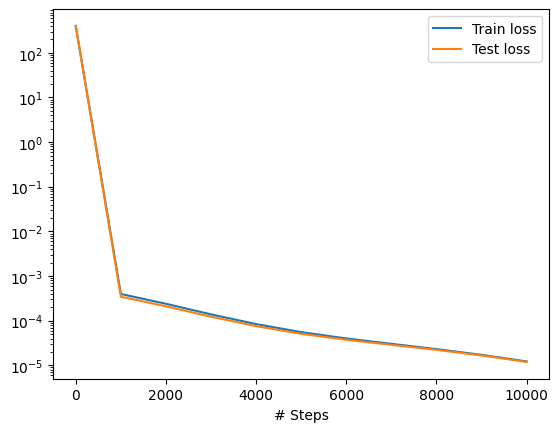

In [29]:
# Define the square domain (e.g., 2x2 square with side length L)

square = dde.geometry.Rectangle([-L, -L], [L, L])

# Define the circular hole at the center (radius R)
  # Radius of the hole
circle = dde.geometry.Disk([0, 0], R)

# Geometry and time domain
geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the initial condition: C(x, y, 0) = 20
def initial_condition(x):
    return 20

# Define Dirichlet boundary conditions (e.g., C = 0 on the boundaries)
def boundary_condition(x, on_boundary):
    return on_boundary

# Create the initial and boundary conditions
ic = dde.icbc.IC(geomtime, lambda x: 20, lambda _, on_initial: on_initial)
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_condition)

data = dde.data.TimePDE(
    geomtime,
    pde_C_L,[ic],
    num_domain=1000,
    num_boundary=150,
    num_initial=180,
    num_test=1000,
    )

# Network for C_L
layer_size = [3] + [64] * 3 + [1]  
activation = "tanh"
initializer = "Glorot uniform"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)



# Define the model with the PDE, initial and boundary conditions
model= dde.Model(data, net_C_L)

# Compile the model with the custom loss function
model.compile("adam", lr=1e-3)

# Add the callback when training the model
losshistory, train_state = model.train(epochs=10000, callbacks=[constraint_callback])

# Optionally plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)